<a href="https://colab.research.google.com/github/gremlin97/EVA-8/blob/main/s9/s9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torchvision.transforms.functional as TF

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


 frog   dog  ship   cat


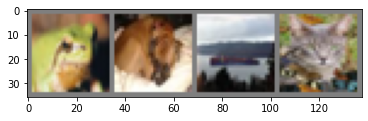

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Ultimus(nn.Module):
    def __init__(self):
        super(Ultimus, self).__init__()
        self.k = nn.Linear(48,8)
        self.q = nn.Linear(48,8)
        self.v = nn.Linear(48,8)
        self.out = nn.Linear(8,48)

    def forward(self, x):
        k = self.k(x)
        q = self.q(x)
        v = self.v(x)
        score = F.softmax(torch.matmul(q,k.T)/torch.sqrt(torch.tensor(k.shape[1])),dim=1)
        attention = torch.matmul(score,v)
        out = self.out(attention)
        return out

In [6]:
ultimus = Ultimus()
out = ultimus(torch.randn(1,48))
print(out)

tensor([[ 0.1107,  0.1657,  0.4207, -0.3416,  0.0210, -0.0840,  0.1083,  0.1488,
          0.2791,  0.5769, -0.4158,  0.1384,  0.7067,  0.2049, -0.6129, -0.0737,
         -0.3591,  0.4200,  0.5054,  0.2056,  0.7540,  0.2728, -0.0543, -0.5005,
         -0.3150, -0.3679,  0.1375,  0.5727, -0.0331,  0.0950,  0.4143,  0.5588,
          0.2147,  0.0465,  0.0217,  0.0096,  0.3850, -0.2449, -0.1072,  0.2816,
          0.0096, -0.4647, -0.5822,  0.0305, -0.2010, -0.1012,  0.0038,  0.6445]],
       grad_fn=<AddmmBackward0>)


In [7]:
class Transformer(nn.Module):
  def __init__(self):
    super(Transformer,self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
    self.conv3 = nn.Conv2d(32, 48, 3, 1, 1)
    self.gap = nn.AdaptiveAvgPool2d((1,1))
    self.ultimusBlock = Ultimus()
    self.cap = nn.Linear(48,10)
  
  def forward(self, x):
      x = self.conv3(F.relu(self.conv2(F.relu(self.conv1(x)))))
      x = self.gap(x)
      x = torch.flatten(x, 1)
      x = self.ultimusBlock(self.ultimusBlock(self.ultimusBlock(self.ultimusBlock(x))))
      x = self.cap(x)
      return x

In [8]:
transformer = Transformer()
out = transformer(torch.randn(2,3,32,32))
print(out)

tensor([[ 0.1837, -0.0895, -0.1349,  0.0171, -0.1019,  0.0015, -0.0968,  0.0130,
         -0.0295,  0.1528],
        [ 0.1837, -0.0895, -0.1349,  0.0171, -0.1019,  0.0015, -0.0968,  0.0130,
         -0.0295,  0.1528]], grad_fn=<AddmmBackward0>)


In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(transformer.parameters(), lr=0.001)

In [10]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = transformer(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.263
[1,  4000] loss: 2.232
[1,  6000] loss: 2.289
[1,  8000] loss: 2.289
[1, 10000] loss: 2.283
[1, 12000] loss: 2.282
[2,  2000] loss: 2.279
[2,  4000] loss: 2.273
[2,  6000] loss: 2.275
[2,  8000] loss: 2.268
[2, 10000] loss: 2.266
[2, 12000] loss: 2.265
Finished Training


In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = transformer(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 13 %
